## Building MetaData

The building metadata file houses data about the buildings for which the meter data has been recorded and gives us information about the type of the building, area covered, energy sources used, etc 

In [7]:
# Importing the required libraries 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'Arial'})

import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
mpl.style.use('ggplot')

import geopandas as gpd
from shapely.geometry import Point, Polygon
import gc

In [8]:
# Specifying the filepath for the data 
path = "../data/metadata/"

In [9]:
# Buildings MetaData data
metadata = pd.read_csv(path + "metadata.csv")

# Inspecting the some columns of the data 
metadata.sample(5)

,building_id,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,lat,lng,...,yearbuilt,date_opened,numberoffloors,occupants,energystarscore,eui,site_eui,source_eui,leed_level,rating
789,Lamb_education_Lucas,Lamb,697.0,5.0,Education,Primary/Secondary Classroom,1737.0,18697.0,51.497838,-3.186246,...,1919.0,NaN,2.0,300.0,NaN,NaN,NaN,NaN,NaN,E
1259,Hog_office_Garrett,Hog,1090.0,13.0,Office,Office,28339.8,305047.0,44.978782,-93.255398,...,NaN,NaN,NaN,NaN,-,78.6,135.6,76.6,NaN,NaN
325,Rat_public_Dalia,Rat,291.0,3.0,Public services,Police Station,8420.3,90635.0,38.903504,-77.005349,...,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874,Peacock_lodging_Francesca,Peacock,749.0,6.0,Lodging/residential,Dormitory,3338.6,35936.0,40.350000,-74.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,Rat_assembly_Myrna,Rat,NaN,3.0,Entertainment/public assembly,Other - Recreation,223.6,2407.0,38.903504,-77.005349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Inspecting the columns of the metadata
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   building_id            1636 non-null   object 
 1   site_id                1636 non-null   object 
 2   building_id_kaggle     1449 non-null   float64
 3   site_id_kaggle         1599 non-null   float64
 4   primaryspaceusage      1615 non-null   object 
 5   sub_primaryspaceusage  1615 non-null   object 
 6   sqm                    1636 non-null   float64
 7   sqft                   1636 non-null   float64
 8   lat                    1399 non-null   float64
 9   lng                    1399 non-null   float64
 10  timezone               1636 non-null   object 
 11  electricity            1578 non-null   object 
 12  hotwater               185 non-null    object 
 13  chilledwater           555 non-null    object 
 14  steam                  370 non-null    object 
 15  wate

## Exploratory Data Analysis (EDA)

### Shape of the Data 

In [11]:
metadata.shape

(1636, 32)

We have building metadata for 1636 buildings 

In [12]:
metadata.dtypes

building_id               object
site_id                   object
building_id_kaggle       float64
site_id_kaggle           float64
primaryspaceusage         object
sub_primaryspaceusage     object
sqm                      float64
sqft                     float64
lat                      float64
lng                      float64
timezone                  object
electricity               object
hotwater                  object
chilledwater              object
steam                     object
water                     object
irrigation                object
solar                     object
gas                       object
industry                  object
subindustry               object
heatingtype               object
yearbuilt                float64
date_opened               object
numberoffloors           float64
occupants                float64
energystarscore           object
eui                       object
site_eui                  object
source_eui                object
leed_level

In [13]:
# Deleting the Kaggle IDs since this data was reproduced for a Kaggle Competion 
metadata = metadata.drop(columns=['building_id_kaggle', 'site_id_kaggle'])

### Missing Values 

In [14]:
# Percentage of missing values in each feature
na_features = [features for features in metadata.columns if metadata[features].isnull().sum() > 0]
for features in na_features:
    # Updated to round the missing values percentage to two decimal places
    print(f"{features} : {round(metadata[features].isnull().mean() * 100, 2)}%")

primaryspaceusage : 1.28%
sub_primaryspaceusage : 1.28%
lat : 14.49%
lng : 14.49%
electricity : 3.55%
hotwater : 88.69%
chilledwater : 66.08%
steam : 77.38%
water : 91.08%
irrigation : 97.74%
solar : 99.69%
gas : 89.18%
industry : 64.61%
subindustry : 64.61%
heatingtype : 86.86%
yearbuilt : 50.06%
date_opened : 98.72%
numberoffloors : 73.04%
occupants : 85.94%
energystarscore : 90.04%
eui : 81.72%
site_eui : 90.04%
source_eui : 90.04%
leed_level : 99.02%
rating : 88.75%


### Feature Exploration 

In [15]:
# Function to divide the different feature data types 
def categorize_variables(df):
    
    categorical = []
    discrete = []
    continuous = []
    datetime = []
    
    for column in df.columns:
        
        if pd.api.types.is_datetime64_any_dtype(df[column]):
            datetime.append(column)
            
        if pd.api.types.is_numeric_dtype(df[column]):
            
            if len(df[column].unique()) / len(df) < 0.05:
                discrete.append(column)
                
            else:
                continuous.append(column)
                
        elif pd.api.types.is_object_dtype(df[column]):
            categorical.append(column)
            
        else:
            categorical.append(column)
    
    return categorical, discrete, continuous, datetime

In [16]:
# Applying the above function to segregate the features 
categorical,discrete,continuous,datetime = categorize_variables(metadata)
numeric = discrete + continuous

print("Categorical: ", categorical)
print("Discrete: ", discrete)
print("Continuous: ", continuous)
print("Numeric: ", numeric)

Categorical:  ['building_id', 'site_id', 'primaryspaceusage', 'sub_primaryspaceusage', 'timezone', 'electricity', 'hotwater', 'chilledwater', 'steam', 'water', 'irrigation', 'solar', 'gas', 'industry', 'subindustry', 'heatingtype', 'date_opened', 'energystarscore', 'eui', 'site_eui', 'source_eui', 'leed_level', 'rating']
Discrete:  ['lat', 'lng', 'numberoffloors']
Continuous:  ['sqm', 'sqft', 'yearbuilt', 'occupants']
Numeric:  ['lat', 'lng', 'numberoffloors', 'sqm', 'sqft', 'yearbuilt', 'occupants']


#### Numeric Variables 

##### Univariate Analysis 

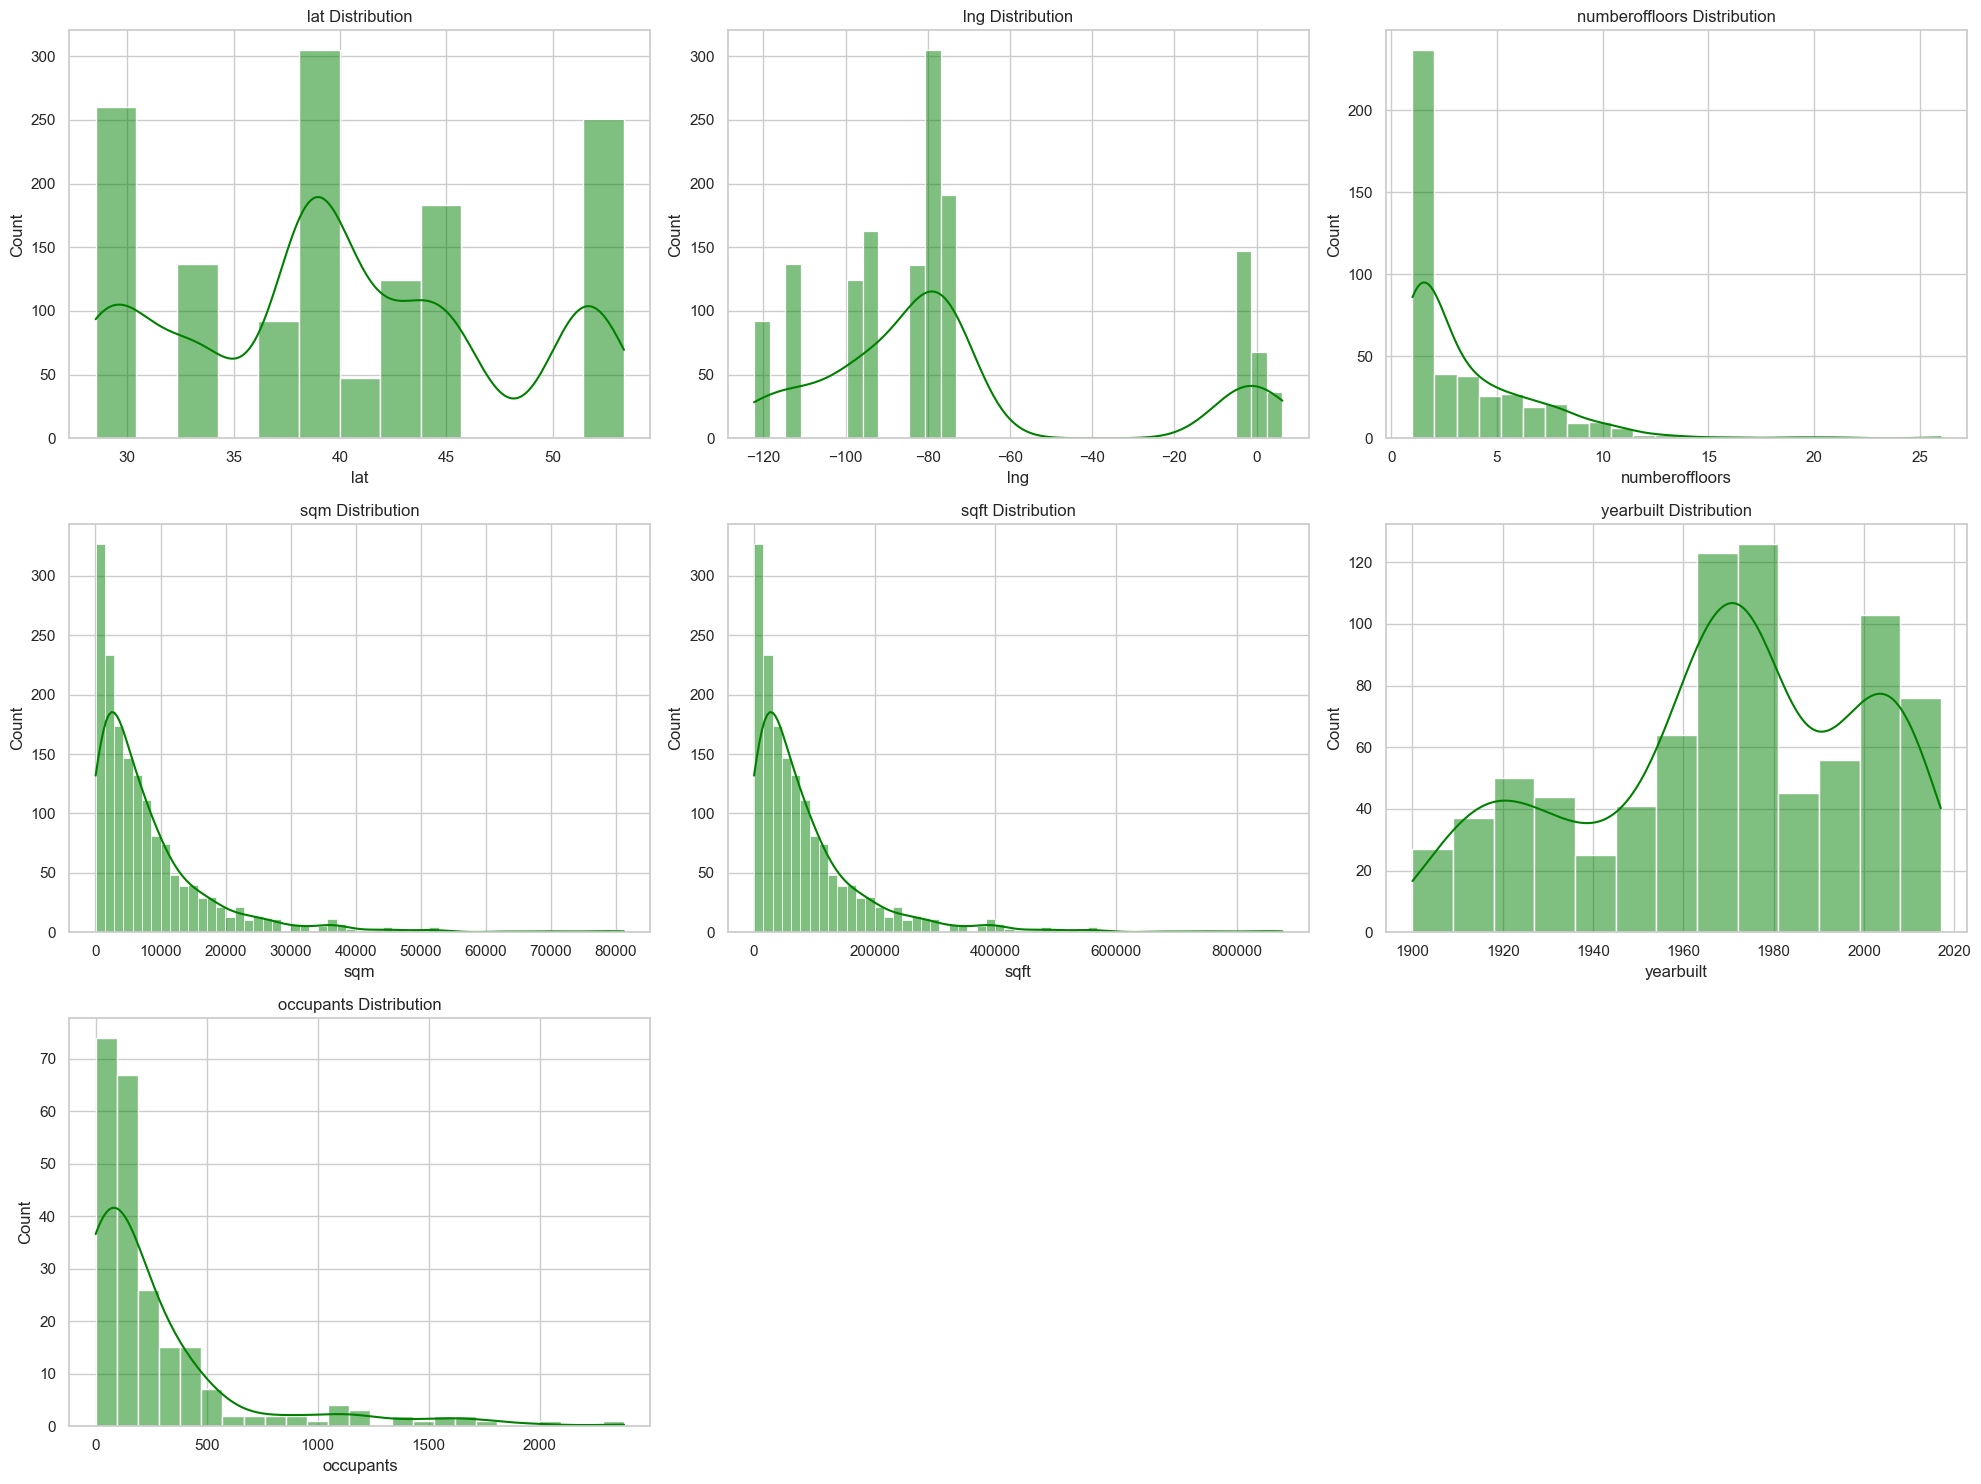

In [17]:
# Looping through all the numeric columns to get a histogram to see distribution 
sns.set(style="whitegrid")  

# Define layout 
num_columns = 3
num_features = len(numeric)  
num_rows = num_features // num_columns + (num_features % num_columns > 0)  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows)) 
axes = axes.flatten()

# Loop through all numeric columns and plot histograms
for i, feature in enumerate(numeric):
    sns.histplot(metadata[feature], kde=True, color="green", ax=axes[i])
    axes[i].set_title(f'{feature} Distribution')  
    axes[i].set_xlabel(feature)  
    axes[i].set_ylabel('Count')  
    axes[i].grid(True)  

for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()  

lat Distribution: This histogram shows the distribution of latitude coordinates for the properties. Most properties are clustered around certain latitude bands, indicating that they are concentrated in specific geographical areas.

lng Distribution: Properties are concentrated in specific longitude bands, suggesting a concentration in particular regions.

sqm Distribution: This graph displays the distribution of property sizes in square meters (sqm). The distribution is heavily right-skewed, meaning most properties are smaller in size, with a few exceptions of very large properties.

sqft Distribution: This is another size distribution, but this time in square feet (sqft). Like the sqm distribution, it is also right-skewed, indicating that most properties are on the smaller side, with fewer large properties.

numberoffloors Distribution: This histogram shows the number of floors in the properties. Most properties have a small number of floors, with a significant drop-off as the number of floors increases.

yearbuilt Distribution: This displays the distribution of the years in which the properties were built. There are several peaks, indicating periods of increased construction activity, particularly around the 1920s, 1960s, and the early 2000s.

occupants Distribution: This graph shows the number of occupants per property. It is extremely right-skewed, with the majority of properties having few occupants and a very small number of properties having a large number of occupants.


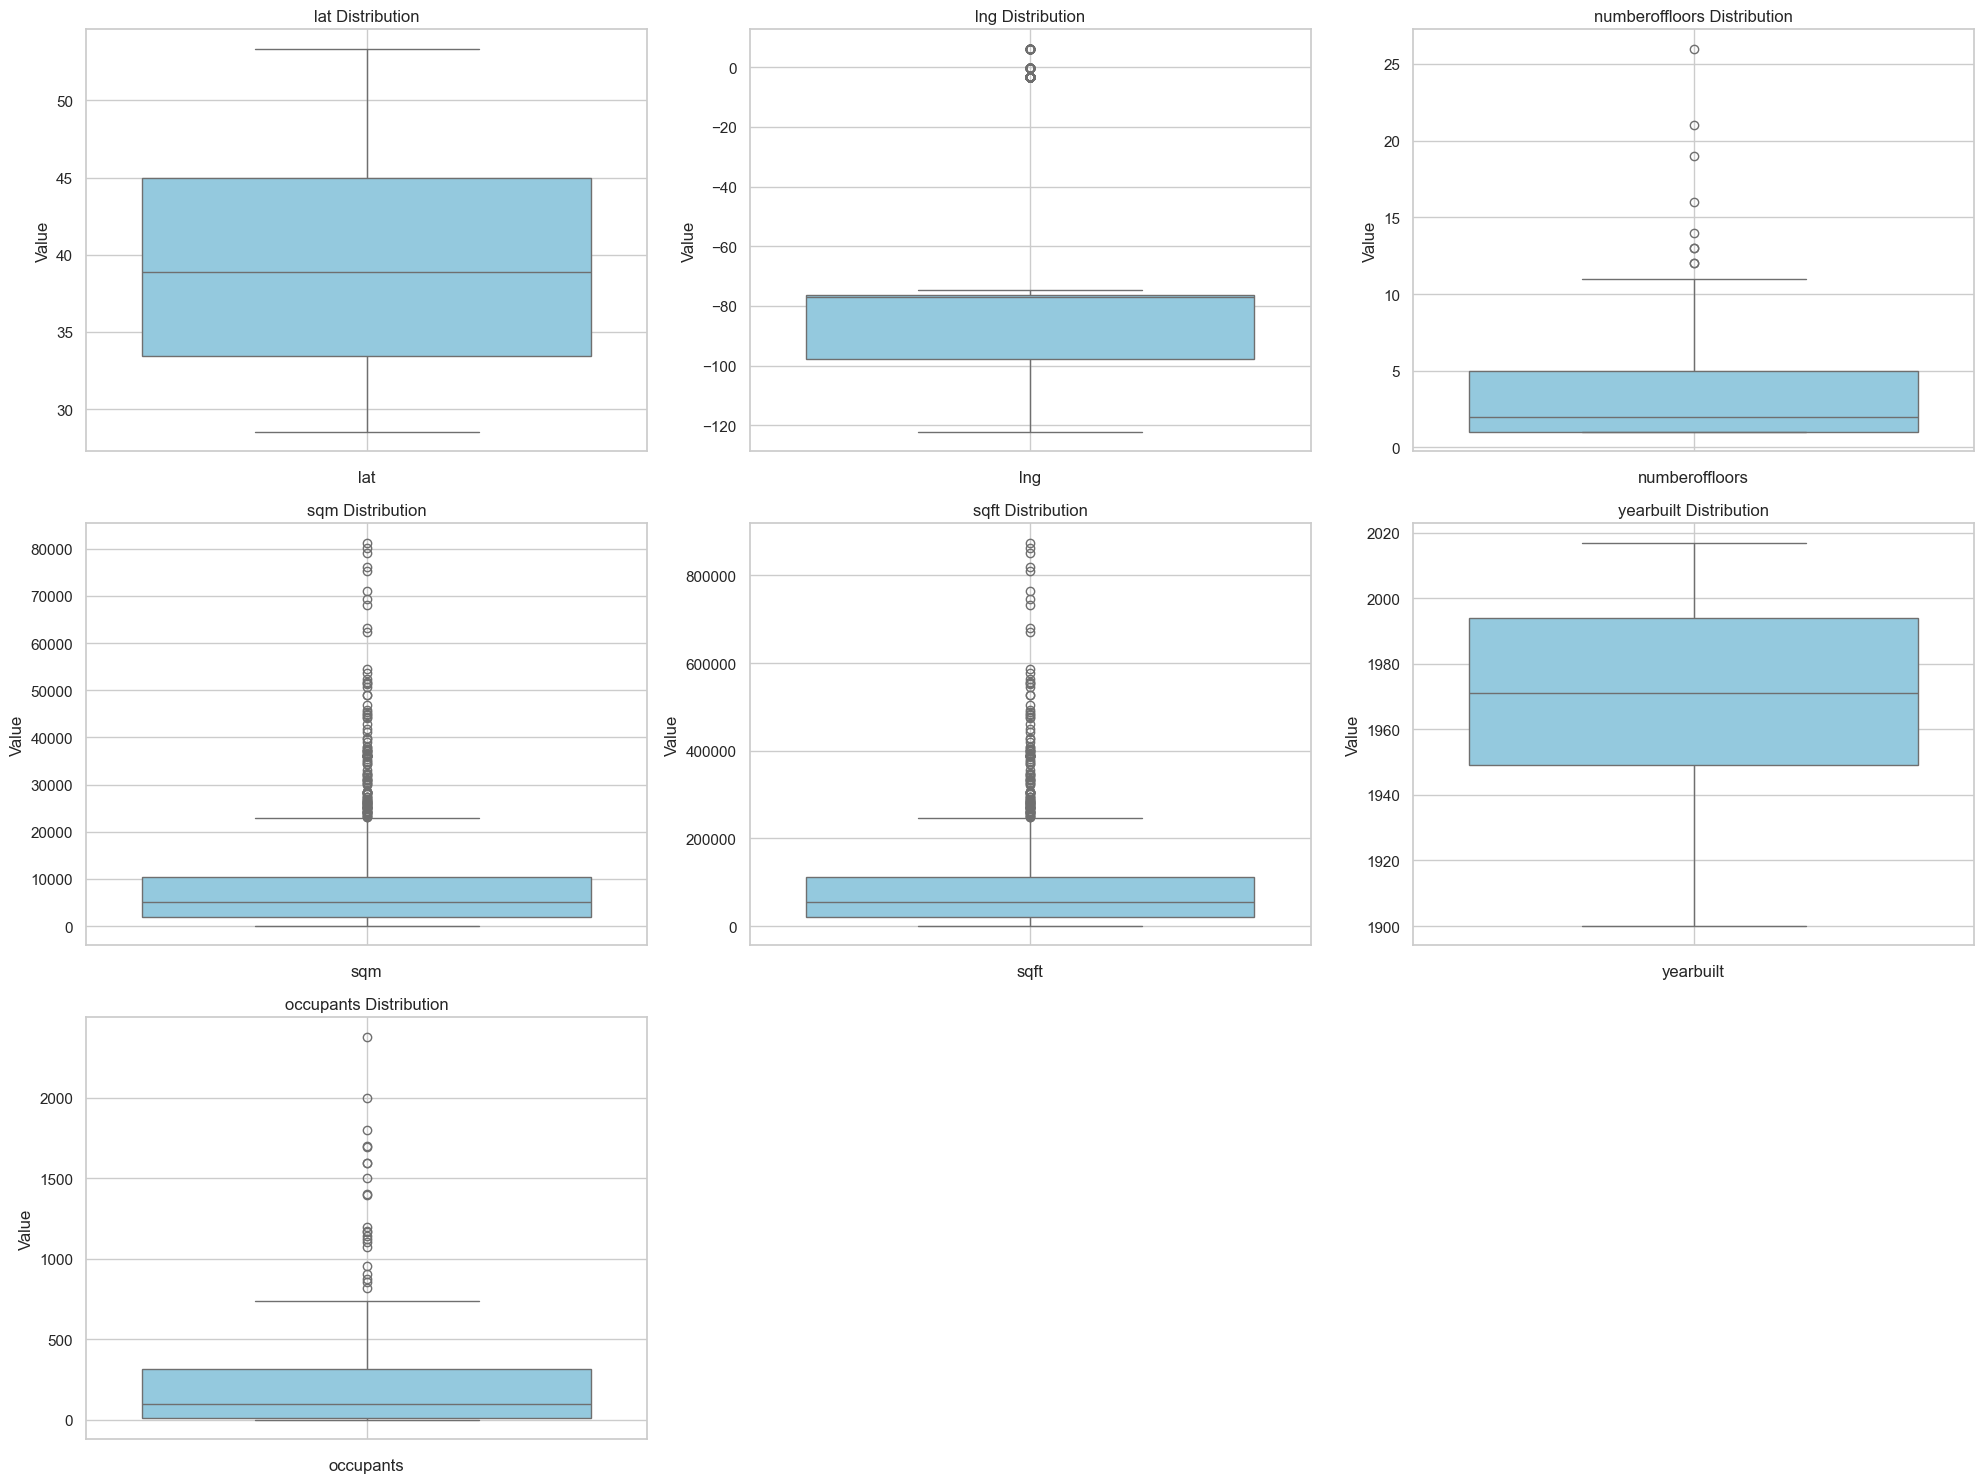

In [30]:
# Looping through all the numeric columns to get a boxplot for outlier detection 
sns.set(style="whitegrid")  

# Define layout 
num_columns = 3
num_features = len(numeric)  
num_rows = num_features // num_columns + (num_features % num_columns > 0)  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows)) 
axes = axes.flatten()

for i, feature in enumerate(numeric):
    sns.boxplot(y=metadata[feature], color="skyblue", ax=axes[i])  
    axes[i].set_title(f'{feature} Distribution')  
    axes[i].set_xlabel(feature)  
    axes[i].set_ylabel('Value')  
    axes[i].grid(True)  

for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

lat Distribution: This box plot shows the distribution of latitude coordinates for properties. The data is concentrated between approximately 35 and 45 degrees with a median around 40 degrees. There are no significant outliers, indicating a relatively uniform distribution within this range.

lng Distribution: The longitude distribution is shown with a box plot that is significantly skewed, with most data falling between 0 and -120 degrees. There are a few outliers indicating locations far from the main cluster.

sqm Distribution: The square meters (sqm) box plot reveals a highly skewed distribution. The majority of properties have small square meter values, with a few extreme outliers representing very large properties.

sqft Distribution: Similar to the sqm distribution, the square feet (sqft) box plot is also highly skewed with most data concentrated at the lower end of the scale and a few large outliers.

numberoffloors Distribution: This box plot indicates that most properties have a small number of floors, typically below 5, with some outliers having significantly more floors.

yearbuilt Distribution: This plot shows the years properties were built, with most falling between 1920 and 2000. The distribution is fairly wide, indicating a variety of property ages, with a median around the 1960s or 1970s.

occupants Distribution: This shows the number of occupants per property, which is heavily skewed towards the lower end. There are numerous outliers indicating some properties with a very high number of occupants, but most properties have fewer occupants.

##### Bivariate Analysis 

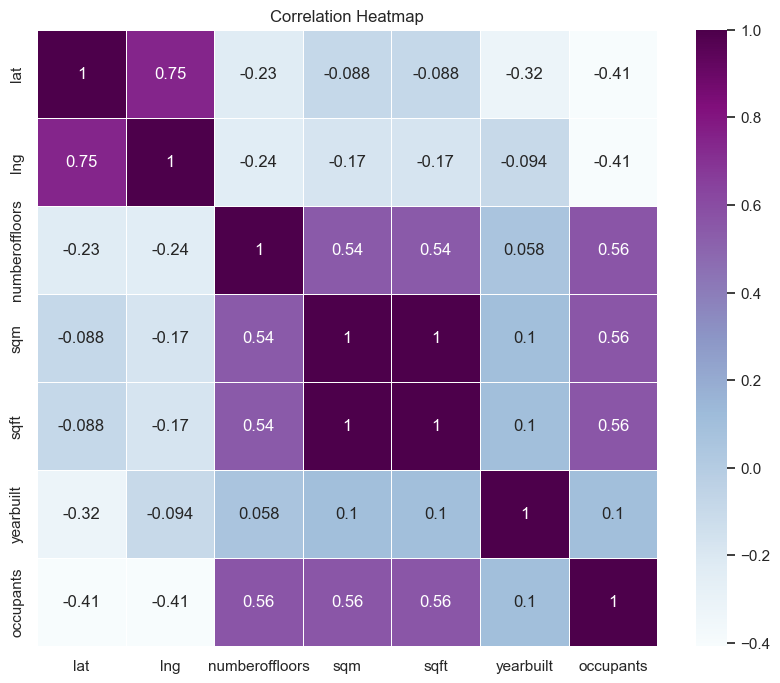

In [31]:
# Correlation plot to assess if there is any synergy between the numeric predictors 
sns.set(style="white")
plt.figure(figsize=(10, 8))  
corr = metadata[numeric].corr() 
sns.heatmap(corr, annot=True, cmap='BuPu', linewidths=.5)  
plt.title('Correlation Heatmap')
plt.show()

Latitude (lat) and Longitude (lng): There is a high positive correlation (0.75) between latitude and longitude, suggesting that in this dataset, properties located further north also tend to be located further in one direction (east or west, depending on the hemisphere).

Number of floors (numberoffloors) and Size (sqm and sqft): Both square meters (sqm) and square feet (sqft) have a moderate positive correlation (0.54) with the number of floors, suggesting that larger properties tend to have more floors.

Size (sqm and sqft): There is a perfect positive correlation (1) between sqm and sqft, which is expected since these are just different units of measurement for the size of a property.

Year built (yearbuilt) and Location (lat, lng): There's a negative correlation between the year a property was built and both latitude (-0.32) and longitude (-0.094), though the correlation is stronger with latitude. This could suggest that newer properties are being built in specific areas of the dataset's geographic scope.

Occupants (occupants) and Size (sqm, sqft), Number of floors (numberoffloors): There is a moderate positive correlation between the number of occupants and both property size (0.56 for both sqm and sqft) and the number of floors (0.56). This indicates that larger properties and those with more floors tend to house more occupants.

Occupants (occupants) and Location (lat, lng): There is a negative correlation between the number of occupants and both latitude (-0.41) and longitude (-0.41), suggesting that properties with more occupants are less likely to be found in locations with higher latitudes and longitudes within this dataset.

#### Categorical Variables 

##### Univariate Analysis - We only plot the top 5 features and bin the "Others" in a category 

/var/folders/46/4q6_331j7qx5_bf3yg_mv9km0000gn/T/ipykernel_77309/2791884959.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total = temp.loc[temp['value']=="Yes"]["value"].value_counts()[0]


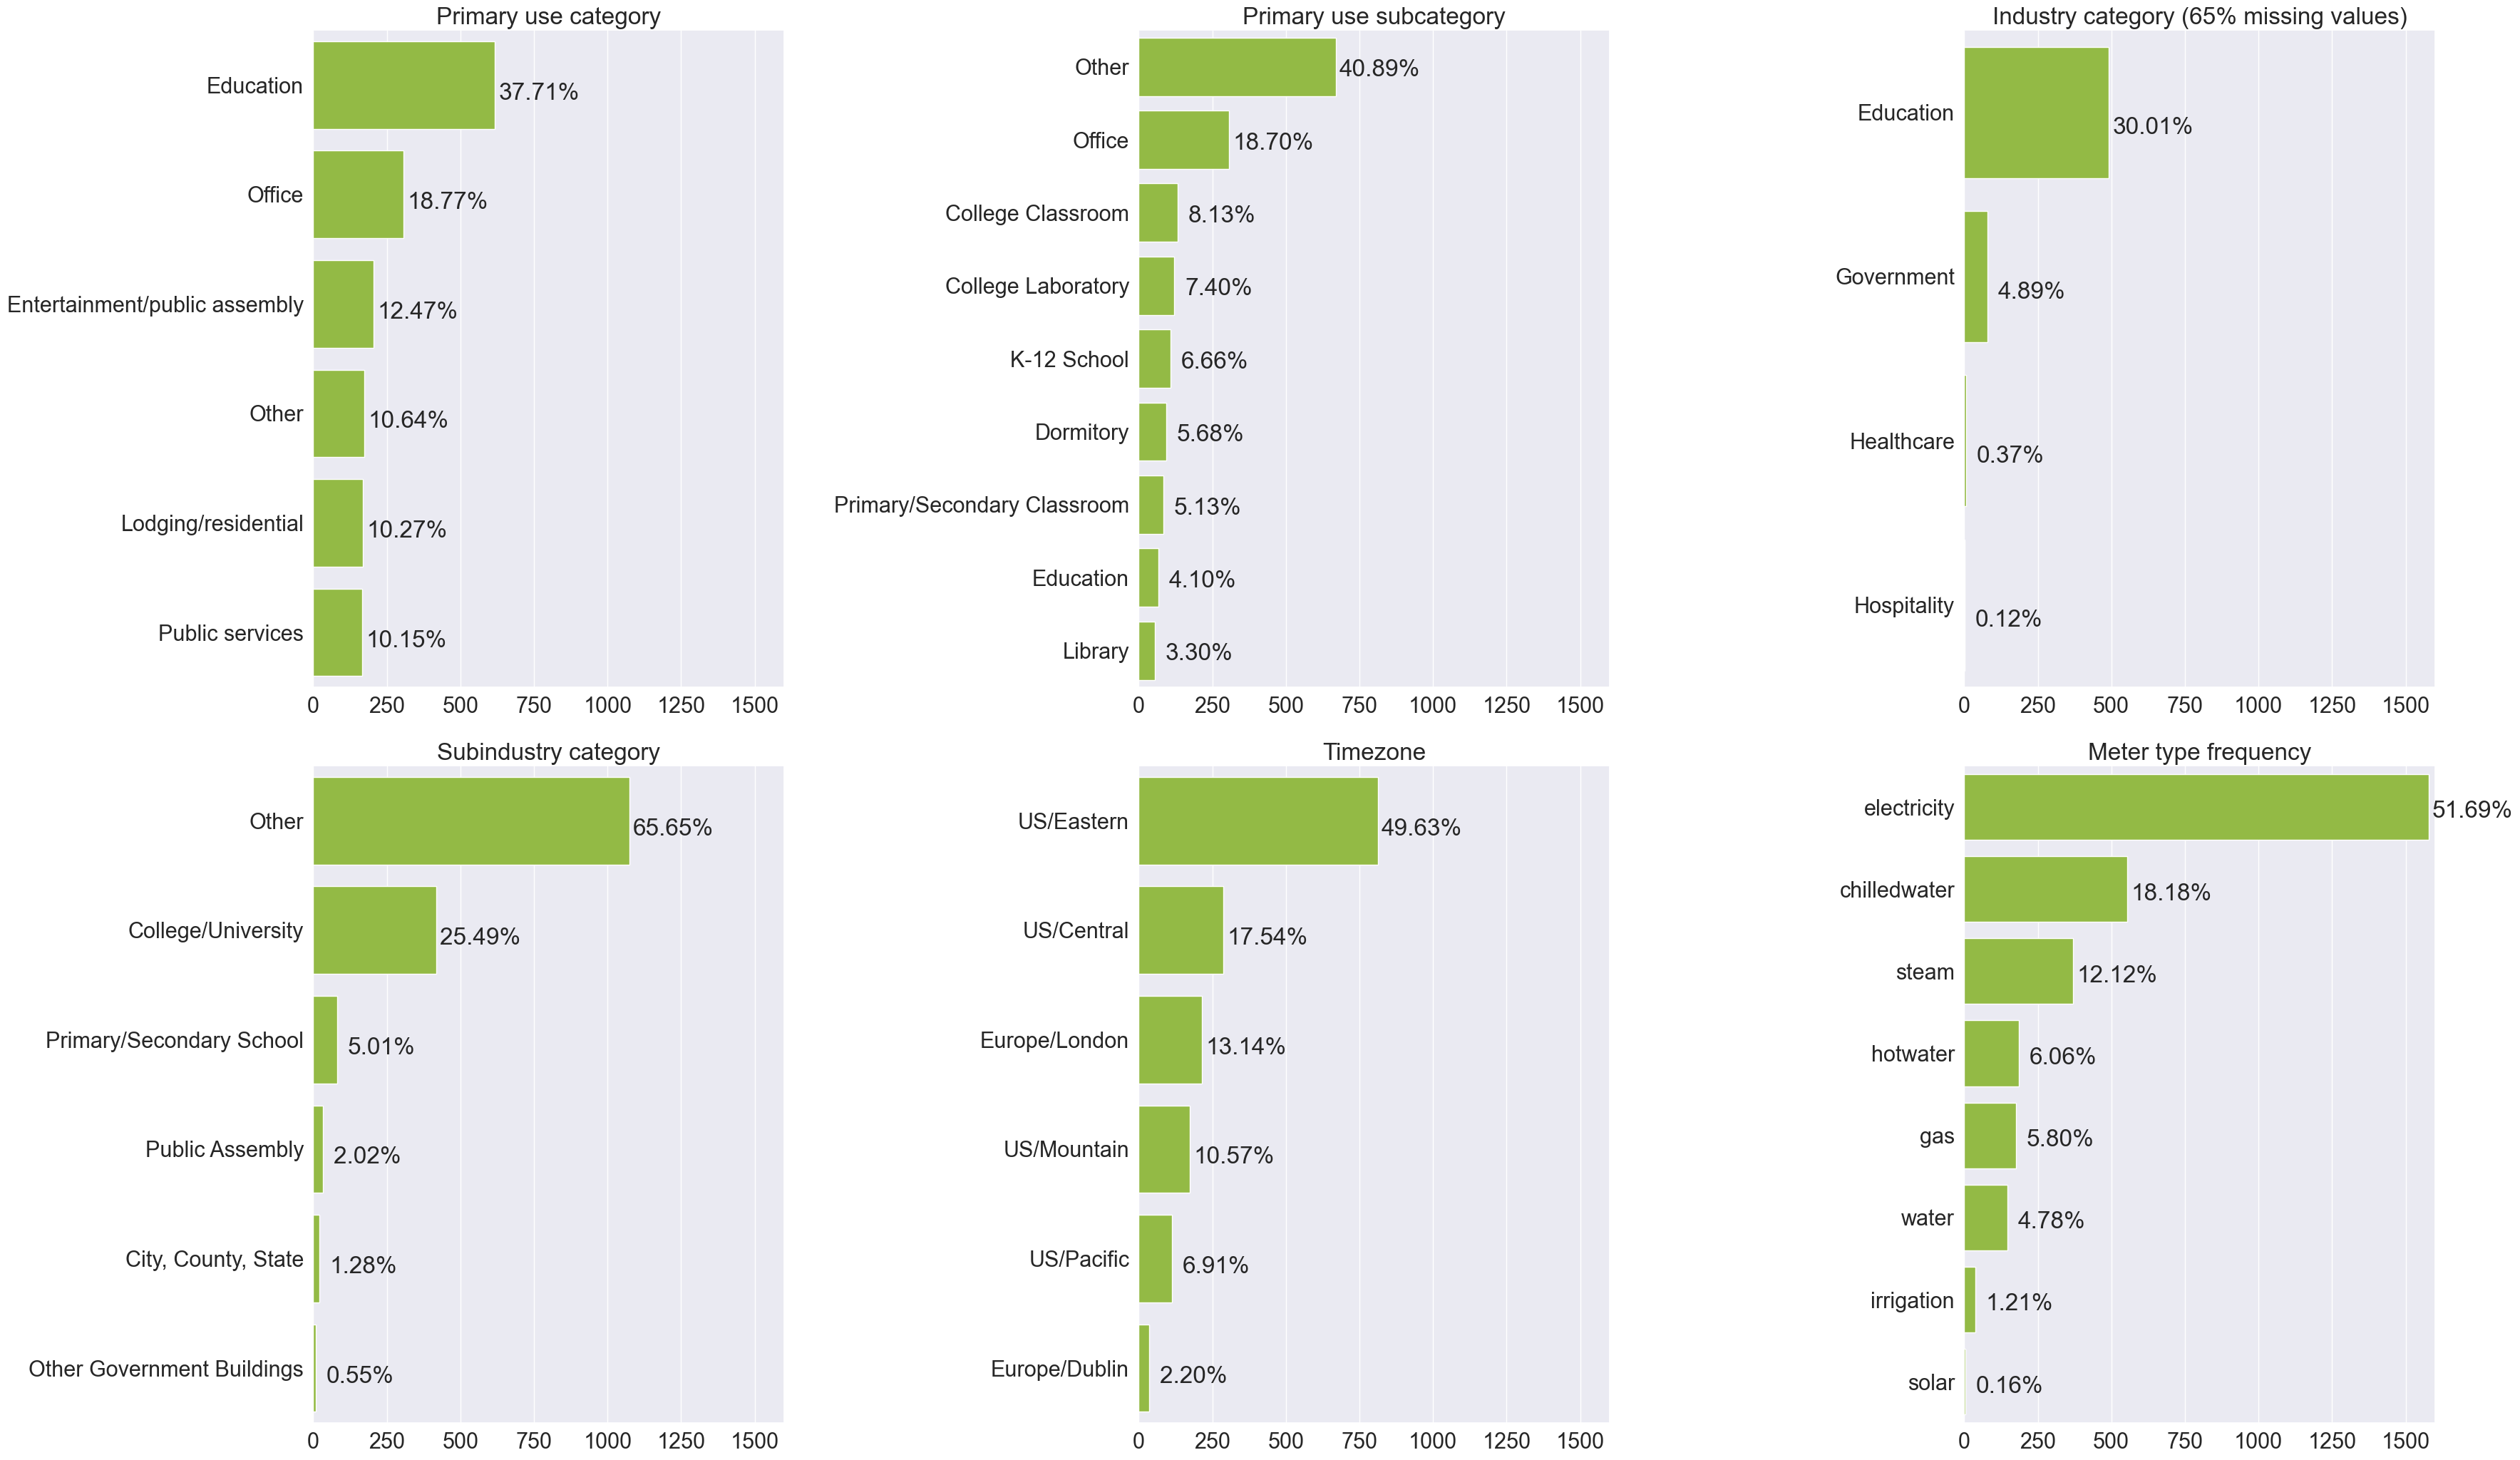

In [34]:
# While there are a lot of categprical features in this data frame, we will do EDA on a select few based on intuition and %missing values
sns.set(rc={'figure.figsize':(36,21)})
sns.set(font_scale = 2)
f, axes = plt.subplots(2, 3)

axes = axes.flatten()

color = "yellowgreen"

# Primary Use Category 
top5 = list(metadata['primaryspaceusage'].value_counts().iloc[:5].index)
temp = metadata[["primaryspaceusage"]].copy()
temp.loc[temp.primaryspaceusage.isin(top5) == False, "primaryspaceusage"] = "Other"
ax1 = axes[0]
g1 = sns.countplot(data=temp, y="primaryspaceusage", color= color, orient="h", ax=ax1, order = temp['primaryspaceusage'].value_counts().index)
ax1.title.set_text('Primary use category')
ax1.set(ylabel="", xlabel="", xlim=(0,1600))  
total = float(len(metadata))
for p in g1.patches:
    width = p.get_width()
    g1.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
del(top5, temp)
    
# Subcategory  
top5 = list(metadata['sub_primaryspaceusage'].value_counts().iloc[:8].index)
temp = metadata[["sub_primaryspaceusage"]].copy()
temp.loc[temp.sub_primaryspaceusage.isin(top5) == False, "sub_primaryspaceusage"] = "Other"
ax2 = axes[1]
g2 = sns.countplot(data=temp, y="sub_primaryspaceusage", color= color, orient="h", ax=ax2, order = temp['sub_primaryspaceusage'].value_counts().iloc[:16].index)
ax2.title.set_text('Primary use subcategory')
ax2.set(ylabel="", xlabel="", xlim=(0,1600))    
total = float(len(metadata)) 
for p in g2.patches:
    width = p.get_width()
    g2.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
del(top5, temp)

# Industry 
ax3 = axes[2]
g3 = sns.countplot(data=metadata, y="industry", color=color, ax=ax3, orient="h", order = metadata['industry'].value_counts().index)
ax3.title.set_text('Industry category (65% missing values)')
ax3.set(ylabel="", xlabel="", xlim=(0,1600))   
total = float(len(metadata)) 
for p in g3.patches:
    width = p.get_width()
    g3.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
    
# Subindustry 
top5 = list(metadata['subindustry'].value_counts().iloc[:5].index)
temp = metadata[["subindustry"]].copy()
temp.loc[temp.subindustry.isin(top5) == False, "subindustry"] = "Other"
ax4 = axes[3]
g4 = sns.countplot(data=temp, y="subindustry", color=color, ax=ax4, orient="h", order = temp['subindustry'].value_counts().index)
ax4.title.set_text('Subindustry category')
ax4.set(ylabel="", xlabel="", xlim=(0,1600))   
total = float(len(metadata))
for p in g4.patches:
    width = p.get_width()
    g4.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
del(top5, temp)

# Timezone
ax5 = axes[4]
g5 = sns.countplot(data=metadata, y="timezone", color=color, ax=ax5, orient="h", order = metadata['timezone'].value_counts().index)
ax5.title.set_text('Timezone')
ax5.set(ylabel="", xlabel="", xlim=(0,1600))   
total = float(len(metadata)) 
for p in g5.patches:
    width = p.get_width()
    g5.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center") 
    
# Meters type frequency
ax6 = axes[5]
temp = pd.melt(metadata[["building_id","electricity","hotwater","chilledwater","steam","water","irrigation","gas","solar"]],id_vars = "building_id", var_name="meter")
g6 = sns.countplot(data=temp.loc[temp['value']=="Yes"], y='meter', color= color, ax=ax6, orient="h", order = temp.loc[temp['value']=="Yes"]["meter"].value_counts().index)
g6.title.set_text('Meter type frequency')
g6.set(ylabel="", xlabel="", xlim=(0,1600))   
total = temp.loc[temp['value']=="Yes"]["value"].value_counts()[0] 
for p in g6.patches:
    width = p.get_width()
    g6.text(width + 150,
            p.get_y() + p.get_height()/1.5,
            '{:1.2%}'.format(width/total),
            ha="center")    
del(temp)
   
plt.tight_layout()

Primary use category: Education and office buildings dominate the primary use categories, indicating a dataset focused mainly on educational and corporate facilities.

Primary use subcategory: There is a large variety classified as "Other", showing diversity, but office spaces and educational rooms like classrooms and laboratories are notably prevalent.

Subindustry category: A significant portion falls under "Other", highlighting variety, yet there's a clear emphasis on educational institutions such as colleges and primary/secondary schools.

Timezone: The properties are predominantly located in the US/Eastern and US/Central time zones, suggesting a geographical focus on the United States, particularly on the eastern side.

Industry category: Education is the most represented sector, but there's a high rate of missing data, which limits detailed conclusions.

Meter type frequency: Electricity is the most commonly measured utility, followed by various water-related services (chilled water, steam, hot water), indicating a focus on tracking energy and water usage.

#### Sites Location Analysis

In [16]:
# World map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Exclude Antartica
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]

# Coordinate reference system used in this map
world.crs

/var/folders/46/4q6_331j7qx5_bf3yg_mv9km0000gn/T/ipykernel_77309/3003188810.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Latitude and longitude are of the site location (all buildings from the same location shares lng and lat values).

In [17]:
# Processing the data so that we can visualise the sites on a map 
sites = metadata[["site_id","lat","lng"]].groupby("site_id").median()

# Converts lat and lng to geometry objects
geometry = [Point(xy) for xy in zip (sites["lng"], sites["lat"])]

# Creates geoDataFrame
geo_sites = gpd.GeoDataFrame(sites, crs = world.crs, geometry = geometry)

(20.0, 60.0)

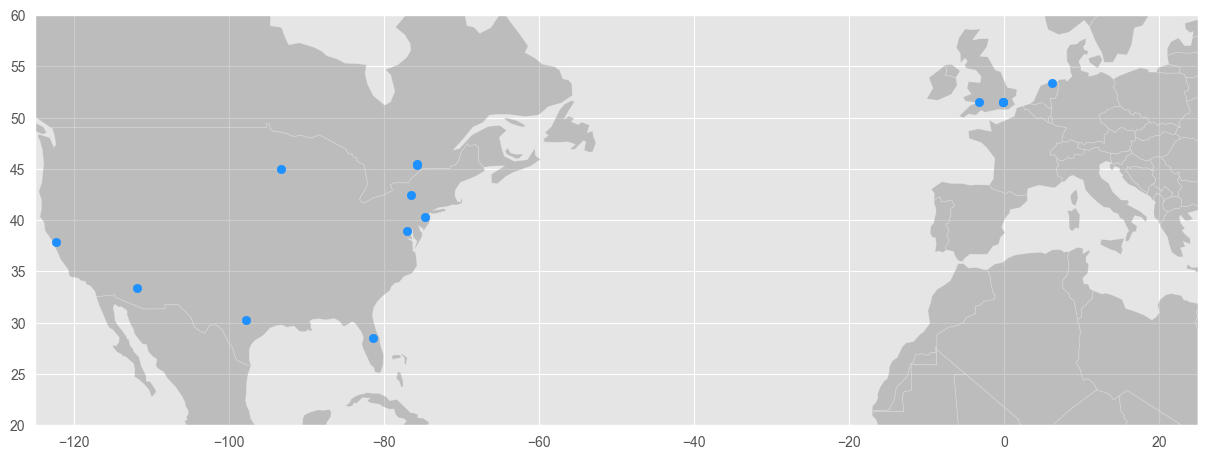

In [18]:
# Plotting the sites on a world map to understand the distribution of our data geographically 
fig, ax = plt.subplots(figsize = (15,15))
world.plot(ax = ax, alpha = 0.4, color = "grey")
geo_sites.plot(ax = ax, color = "dodgerblue")
ax.set_xlim([-125, 25])
ax.set_ylim([20, 60])

Distribution: The plotted points are more concentrated in the North American region, particularly between latitudes 30 to 50 degrees and longitudes from -120 to -70 degrees. This could indicate a higher number of relevant sites or data collection points in the United States.

European Presence: There are a few points scattered across the European region, particularly between latitudes 40 to 55 degrees and longitudes from -10 to 20 degrees. This suggests some presence or relevance in European countries as well, though less than in North America.

Geographic Spread: The points cover a broad geographic area, indicating the dataset's wide spatial coverage. However, there are no points in the southern hemisphere or in Asia, Africa, or South America, which could reflect the regional focus of the data or project.



##### Bivariate Analysis 

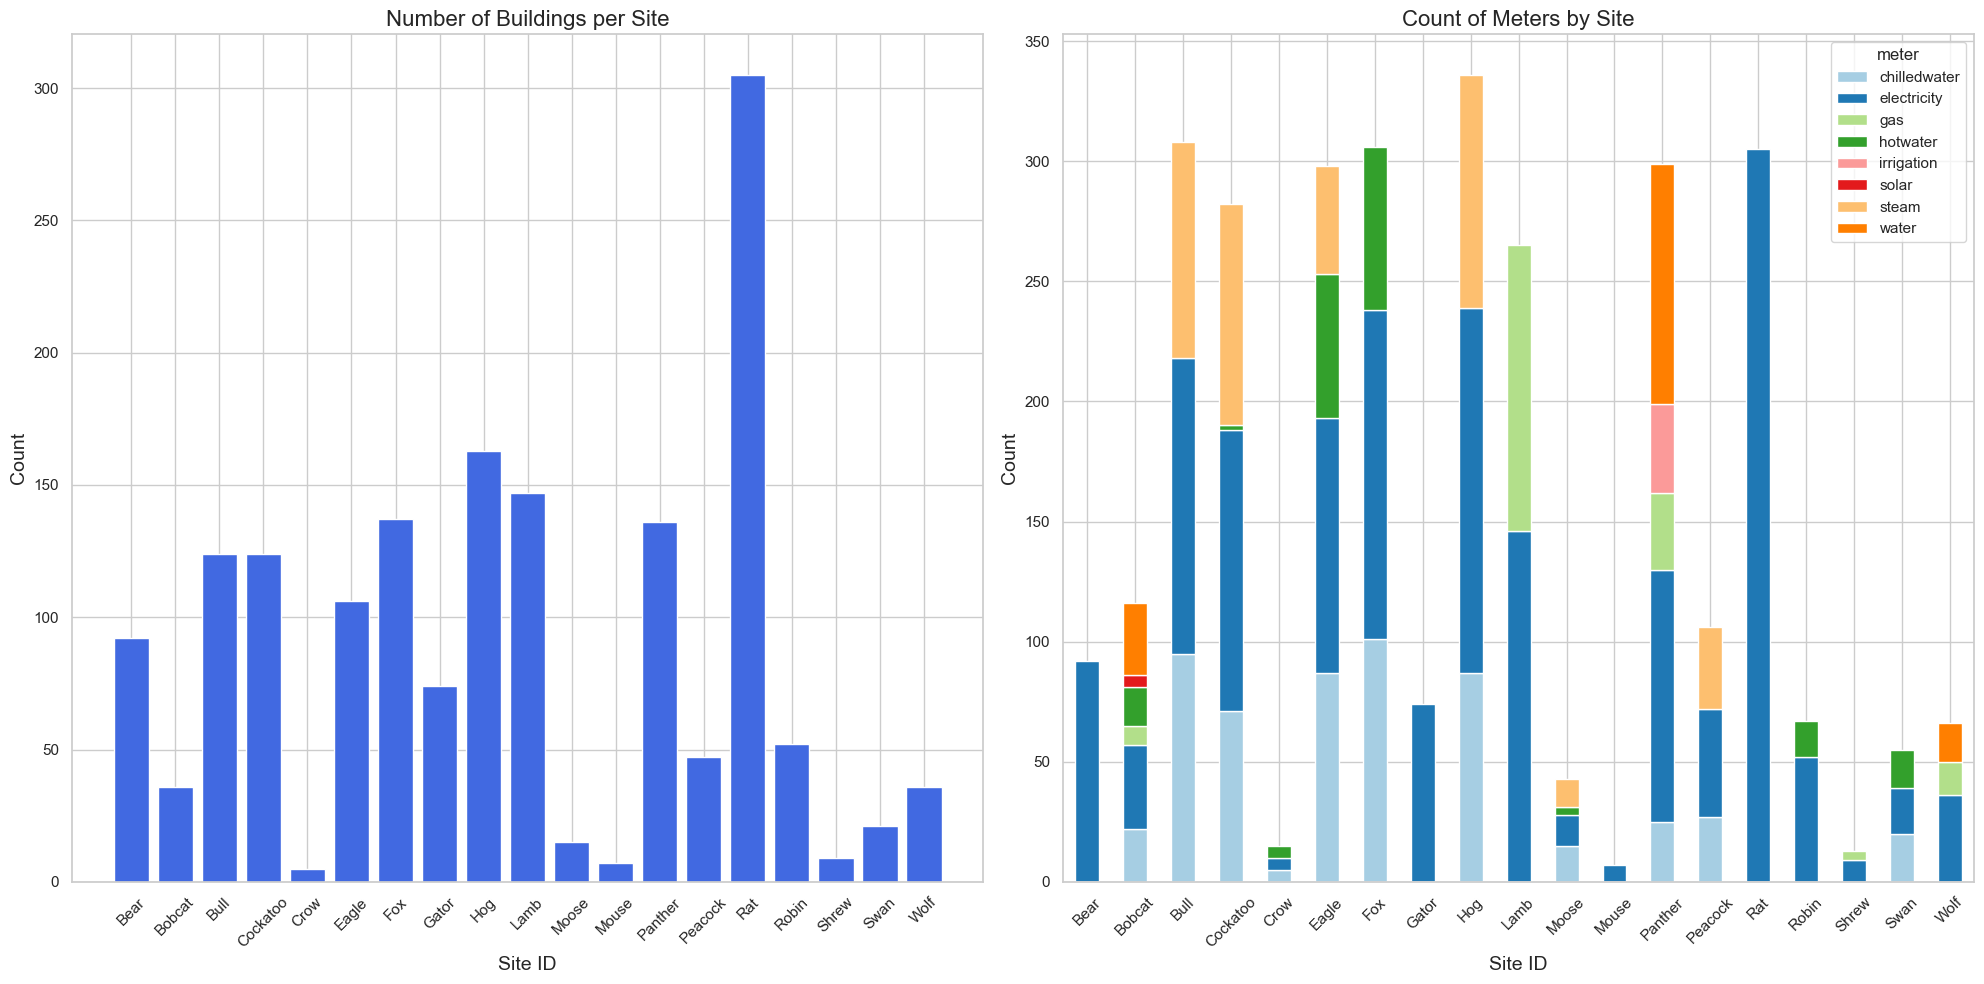

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Two plots side by side

# Number of buildings in each site 
building_counts = metadata.groupby("site_id").building_id.count()
axes[0].bar(building_counts.index, building_counts.values, color='royalblue')  
axes[0].set_title('Number of Buildings per Site', fontsize=16)
axes[0].set_xlabel('Site ID', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Count of different meters by site
temp = pd.melt(metadata[["site_id", "electricity", "hotwater", "chilledwater", "steam", "water", "irrigation", "gas", "solar"]],
               id_vars="site_id", var_name="meter")
bysite = temp[temp.value == "Yes"].groupby(["site_id", "meter"]).size().unstack(fill_value=0)
palette = sns.color_palette("Paired", len(bysite.columns))
bysite.plot(kind="bar", stacked=True, ax=axes[1], color=palette)
axes[1].set_title('Count of Meters by Site', fontsize=16)
axes[1].set_xlabel('Site ID', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [21]:
print("Total number of meters: " + str(len(temp.dropna())))

Total number of meters: 3053


There is significant variation in the number of buildings among different sites.
Electricity is the most common meter type across sites, reflecting its essential role.
The presence of chilled water and steam meters in some sites may indicate specialized cooling and heating systems, likely in larger or more complex facilities.
Other meter types like gas, hot water, and solar are less uniformly distributed, suggesting site-specific utility usage and infrastructure.
